In [1]:
from picamera.array import PiYUVArray
from picamera import PiCamera

from scipy.signal import find_peaks, butter, filtfilt
from pwm import PWM

import time
import matplotlib.pyplot as plt
import skimage as ski

# Camera resolution
res = (640, 480)

# Run a track detection algorithm on a single horizontal line.
# Uses YUV420 image format as the Y component corresponds to image intensity (gray image)
# and thus there is no need to convert from RGB to BW

camera = PiCamera()
        
# Check the link below for the combinations between mode and resolution
# https://picamera.readthedocs.io/en/release-1.13/fov.html#sensor-modes
camera.sensor_mode = 7
camera.resolution = res
camera.framerate = 120

# To filter the noise in the image we use a 3rd order Butterworth filter

# Wn = 0.02, the cut-off frequency, acceptable values are from 0 to 1
b, a = butter(3, 0.02)

pwm0 = PWM(0)
pwm1 = PWM(1)

pwm0.export()
pwm1.export()

pwm0.period = 20000000
pwm1.period = 20000000

pwm0.enable = True
pwm1.enable = True

In [2]:
pwm0.duty_cycle = 1000000
pwm1.duty_cycle = 1100000
time.sleep(1)
pwm1.duty_cycle = 2100000
time.sleep(1)
pwm1.duty_cycle = 1600000

In [ ]:
rawCapture = PiYUVArray(camera, size=res)
stream = camera.capture_continuous(rawCapture, format="yuv", use_video_port=True)

#CENTER is 1600000
#RIGHT is  1100000
#LEFT is   2100000
#for pwm1
#duty_cycle

#      (array([482, 542], dtype=int32), {'peak_heights': array([186.831036  , 185.01286929])})

numFrames = 0

#if linePos is 1 then the line is to the right of the car
#if linePos is -1 then the line is to the left of the car
#if linePos is 0 either uhoh we're doomed
#if lost is true then the line is lost

linePos = 0
lost = False

pwm0.duty_cycle = 1100000

for f in stream:
    if pwm0.duty_cycle == 1000000:
        break
    
    numFrames += 1
    # Get the intensity component of the image (a trick to get black and white images)
    I = f.array[:, :, 0]
    
    # Reset the buffer for the next image
    rawCapture.truncate(0)
    
    # Select a horizontal line in the middle of the image
    L = I[240, :]

    # Smooth the transitions so we can detect the peaks 
    Lf = filtfilt(b, a, L)

    # Find peaks which are higher than 0.5
    p = find_peaks(Lf, height=128)
    
    totalPeakAmt = 0
    avgPeakLoc = -1
    numPeaks = 0
    
    for peak in p[0]:
        numPeaks += 1
        totalPeakAmt += peak
        
    if numPeaks != 0:
        avgPeakLoc = totalPeakAmt / numPeaks
    
    if avgPeakLoc != -1 :
        lost = False
        
        if avgPeakLoc < 320:
            linePos = -1
        else:
            linePos = 1
            
        pwm1.duty_cycle = int(1600000 - ((avgPeakLoc - 320)/320)*500000)
    else:
        lost = True
        
        if linePos == -1:
            pwm1.duty_cycle = 2100000
        elif linePos == 1:
            pwm1.duty_cycle = 1100000
        else:
            pwm1.duty_cycle = 1600000
    
    print(avgPeakLoc)
    print(pwm1.duty_cycle)
    print(lost)
    print(linePos)
    
        
    #plt.imshow(I)
    
    time.sleep(0.2)
    
# Release resources
stream.close()
rawCapture.close()
camera.close()

251.5
1707031
False
-1
272.5
1674218
False
-1
341.0
1567187
False
1
393.0
1485937
False
1
379.5
1507031
False
1
312.5
1611718
False
-1
197.5
1791406
False
-1
79.5
1975781
False
-1
97.0
1948437
False
-1
80.5
1974218
False
-1
75.5
1982031
False
-1
108.0
1931250
False
-1
66.0
1996875
False
-1
-1
2100000
True
-1
-1
2100000
True
-1
-1
2100000
True
-1
-1
2100000
True
-1
23.0
2064062
False
-1
68.0
1993750
False
-1
118.0
1915625
False
-1
118.0
1915625
False
-1
176.0
1825000
False
-1
235.0
1732812
False
-1
268.0
1681250
False
-1
270.5
1677343
False
-1
263.0
1689062
False
-1
264.0
1687500
False
-1
279.0
1664062
False
-1
299.0
1632812
False
-1
317.0
1604687
False
-1
353.0
1548437
False
1
428.5
1430468
False
1
507.5
1307031
False
1
529.5
1272656
False
1
536.0
1262500
False
1
550.0
1240625
False
1
509.0
1304687
False
1
526.0
1278125
False
1
592.0
1175000
False
1
-1
1100000
True
1
539.0
1257812
False
1
448.0
1400000
False
1
312.0
1612500
False
-1
219.5
1757031
False
-1
190.5
1802343
False
-1
159.5
1

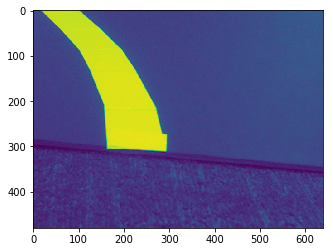

In [3]:
plt.imshow(I)

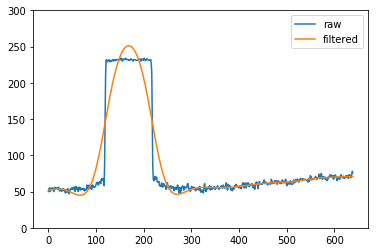

In [4]:
plt.plot(L, label="raw")
plt.plot(Lf, label="filtered")
plt.ylim([0, 300])
plt.legend()

In [ ]:
camera.close()

In [ ]:
pwm0.duty_cycle = 1000000

In [1]:
from pwm import PWM

pwm0 = PWM(0)

pwm0.export()

pwm0.duty_cycle = 1000000

pwm0.period = 20000000

pwm0.enable = True